# Sign Detection with Inception V3

### Loading Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.models import Model
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras import layers
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Image Data Augmentation

In [2]:
# ImageDataGenerator
datagen = ImageDataGenerator(
    validation_split=0.2,
         rotation_range=10, # rotation
         width_shift_range=0.2, # horizontal shift
         height_shift_range=0.2, # vertical shift
         zoom_range=0.2, # zoom
         horizontal_flip=True, # horizontal flip
         brightness_range=[0.2,1.2]) # brightness

data_dir = "ISL-Original/Training"
test_datagen=ImageDataGenerator(validation_split=0.2)
train_ds = datagen.flow_from_directory(data_dir,
                                           class_mode = 'categorical',
                                           target_size = (150, 150),
                                           batch_size=64,
                                       subset='training',
                                           seed=46)
val_ds = test_datagen.flow_from_directory(data_dir,
                                     class_mode = 'categorical',
                                     target_size = (150, 150),
                                     batch_size=64,
                                          subset='validation',
                                     seed=46)

Found 8803 images belonging to 26 classes.
Found 2189 images belonging to 26 classes.


### Declare Metrics 

In [3]:
from tensorflow.keras import backend as K
def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

### Implement the Deep Learning Model - Inception V3

In [4]:
inception_base_model = InceptionV3(input_shape = (150,150,3), include_top = False, weights = "imagenet")
inception_base_model.trainable = False

inputs = tf.keras.Input(shape=(150,150,3))

x = inception_base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(26, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [10]:
inception_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 26)                53274     
Total params: 21,856,058
Trainable params: 53,274
Non-trainable params: 21,802,784
_________________________________________________________________


In [6]:
#fit the model
#it will take some time to train
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics = ['accuracy',f1, precision,recall])
history = model.fit(train_ds, epochs =20, batch_size = 64,validation_data=val_ds)

Epoch 1/20
138/138 [==============================] - 245s 2s/step - loss: 13.7846 - accuracy: 0.2349 - f1: 0.2343 - precision: 0.2432 - recall: 0.2261 - val_loss: 8.7683 - val_accuracy: 0.3595 - val_f1: 0.3606 - val_precision: 0.3664 - val_recall: 0.3552
Epoch 2/20
138/138 [==============================] - 243s 2s/step - loss: 8.2188 - accuracy: 0.3501 - f1: 0.3533 - precision: 0.3654 - recall: 0.3420 - val_loss: 7.6829 - val_accuracy: 0.4915 - val_f1: 0.4834 - val_precision: 0.4862 - val_recall: 0.4807
Epoch 3/20
138/138 [==============================] - 246s 2s/step - loss: 7.5833 - accuracy: 0.4159 - f1: 0.4175 - precision: 0.4294 - recall: 0.4064 - val_loss: 6.2207 - val_accuracy: 0.5381 - val_f1: 0.5388 - val_precision: 0.5418 - val_recall: 0.5359
Epoch 4/20
138/138 [==============================] - 246s 2s/step - loss: 6.9103 - accuracy: 0.4497 - f1: 0.4522 - precision: 0.4641 - recall: 0.4411 - val_loss: 8.7319 - val_accuracy: 0.4947 - val_f1: 0.4982 - val_precision: 0.5009 

### Learning Curves - Graph 

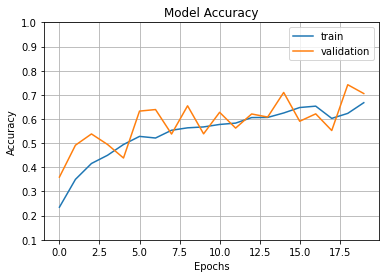

In [7]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

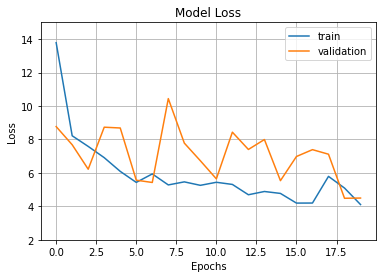

In [9]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=2,ymax=15)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Evaluating the Model 

In [10]:
Y_pred = model.predict_generator(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

Text(0.5, 33.0, 'Predicted label')

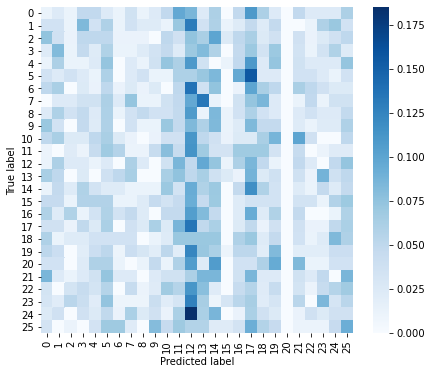

In [11]:
cf_mat = confusion_matrix(val_ds.classes, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 6))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [12]:
model.save('inception_signd.h5')

In [13]:
labels = val_ds.classes
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.01      0.01      0.01        82
           1       0.04      0.04      0.04        84
           2       0.03      0.01      0.02        80
           3       0.05      0.05      0.05        85
           4       0.03      0.02      0.03        82
           5       0.04      0.06      0.05        83
           6       0.03      0.01      0.02        80
           7       0.09      0.07      0.08        82
           8       0.11      0.05      0.07        83
           9       0.02      0.01      0.01        84
          10       0.03      0.04      0.04        80
          11       0.03      0.05      0.04        88
          12       0.02      0.05      0.03        82
          13       0.04      0.06      0.05        79
          14       0.05      0.07      0.06        85
          15       0.00      0.00      0.00        86
          16       0.02      0.02      0.02        85
          17       0.02    

['H']

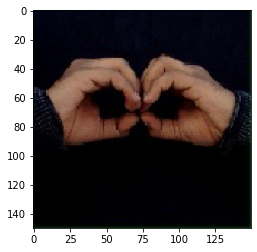

In [23]:
#Creating a dictionary to map each of the indexes to the corresponding number or letter
from keras.preprocessing import image
dict = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",
        11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",
        24:"Y",25:"Z"}


#Predicting images

img = image.load_img("sign_B2.jpg", target_size=(150, 150))
x = image.img_to_array(img)
plt.imshow(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = model.predict(image, batch_size=64)
label = [np.argmax(i) for i in classes]
pred_class=[dict[x] for x in label]
pred_class

In [24]:
loss, accuracy, f1_score, precision, recall = model.evaluate(val_ds, verbose=0)

In [26]:
print(f"Test Loss: ", round(loss*100, 3), '%')
print(f"Test Accuracy: ", round(accuracy*100, 3), '%')
print(f"Test Precision: ", round(precision*100, 3), '%')
print(f"Test Recall: ",round(recall*100, 3), '%')
print(f"Test F1 Score: ",round(f1_score*100, 3), '%')

Test Loss:  449.571 %
Test Accuracy:  70.534 %
Test Precision:  71.123 %
Test Recall:  70.677 %
Test F1 Score:  70.897 %


In [ ]:
print(f"Test Loss: ", loss)
print(f"Test Accuracy: ", a)
print(f"Test Precision: ", round(precision*100, 3), '%')
print(f"Test Recall: ",round(recall*100, 3), '%')
print(f"Test F1 Score: ",round(f1_score*100, 3), '%')